# Model Training Visualization and Explanation

This notebook visualizes and explains the model training process for fraud detection using the `Fraud_Data` and `creditcard` datasets. We implement Logistic Regression and XGBoost, apply SMOTE for imbalance handling, and evaluate with AUC-PR, F1-Score, and Confusion Matrices. Visualizations include confusion matrices and precision-recall curves to interpret model performance.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## Data Preparation

We load, clean, and preprocess the datasets, then apply SMOTE to handle class imbalance.

In [5]:
# Load data 
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')
creditcard_df = pd.read_csv('../data/creditcard.csv')

# Clean data (drop missing values and duplicates)
fraud_df = fraud_df.dropna().drop_duplicates()
creditcard_df = creditcard_df.dropna().drop_duplicates()

## Merge IP data (with IntervalTree)
from intervaltree import IntervalTree
def merge_ip_data(fraud_df, ip_df):
    print("Merging IP address data...")
    fraud_df['ip_address_int'] = fraud_df['ip_address'].astype(int)
    
    # Create IntervalTree for efficient IP range lookup
    ip_tree = IntervalTree()
    for _, row in ip_df.iterrows():
        ip_tree[row['lower_bound_ip_address']:row['upper_bound_ip_address'] + 1] = row['country']
    
    # Map IP to country
    def get_country(ip):
        intervals = ip_tree[ip]
        return intervals.pop().data if intervals else 'Unknown'
    
    fraud_df['country'] = fraud_df['ip_address_int'].apply(get_country)
    fraud_df = fraud_df.drop(columns=['ip_address_int'])
    print("Merging completed.")
    return fraud_df
fraud_df = merge_ip_data(fraud_df, ip_df)
# Preprocess data
fraud_categorical = ['source', 'browser', 'sex', 'country']
fraud_numerical = ['purchase_value', 'age']
creditcard_numerical = [f'V{i}' for i in range(1, 29)] + ['Amount']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), fraud_categorical),
        ('num', StandardScaler(), fraud_numerical)
    ]
)

X_fraud = fraud_df.drop(columns=['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
y_fraud = fraud_df['class']
X_creditcard = creditcard_df.drop(columns=['Class', 'Time'])
y_creditcard = creditcard_df['Class']

X_fraud_processed = preprocessor.fit_transform(X_fraud)
scaler = StandardScaler()
X_creditcard_processed = scaler.fit_transform(X_creditcard)

# Split data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud_processed, y_fraud, test_size=0.2, random_state=42)
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(X_creditcard_processed, y_creditcard, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud, y_train_fraud)
X_train_creditcard_res, y_train_creditcard_res = smote.fit_resample(X_train_creditcard, y_train_creditcard)

print("Data preparation and SMOTE applied successfully.")

Merging IP address data...
Merging completed.
Data preparation and SMOTE applied successfully.


## Model Training and Evaluation

We train Logistic Regression and XGBoost on the resampled data and evaluate using AUC-PR, F1-Score, and Confusion Matrices.

In [6]:
# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return auc_pr, f1, cm, precision, recall, y_prob

# Train and evaluate Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
auc_pr_lr_fraud, f1_lr_fraud, cm_lr_fraud, prec_lr_fraud, rec_lr_fraud, prob_lr_fraud = evaluate_model(
    lr, X_train_fraud_res, X_test_fraud, y_train_fraud_res, y_test_fraud, "Fraud_Data"
)
auc_pr_lr_credit, f1_lr_credit, cm_lr_credit, prec_lr_credit, rec_lr_credit, prob_lr_credit = evaluate_model(
    lr, X_train_creditcard_res, X_test_creditcard, y_train_creditcard_res, y_test_creditcard, "Creditcard"
)

# Train and evaluate XGBoost
xgb = XGBClassifier(random_state=42, scale_pos_weight=10)
auc_pr_xgb_fraud, f1_xgb_fraud, cm_xgb_fraud, prec_xgb_fraud, rec_xgb_fraud, prob_xgb_fraud = evaluate_model(
    xgb, X_train_fraud_res, X_test_fraud, y_train_fraud_res, y_test_fraud, "Fraud_Data"
)
auc_pr_xgb_credit, f1_xgb_credit, cm_xgb_credit, prec_xgb_credit, rec_xgb_credit, prob_xgb_credit = evaluate_model(
    xgb, X_train_creditcard_res, X_test_creditcard, y_train_creditcard_res, y_test_creditcard, "Creditcard"
)

# Print results
print("\\nLogistic Regression Results:")
print(f"Fraud_Data - AUC-PR: {auc_pr_lr_fraud:.4f}, F1-Score: {f1_lr_fraud:.4f}")
print(f"Creditcard - AUC-PR: {auc_pr_lr_credit:.4f}, F1-Score: {f1_lr_credit:.4f}")
print("\\nXGBoost Results:")
print(f"Fraud_Data - AUC-PR: {auc_pr_xgb_fraud:.4f}, F1-Score: {f1_xgb_fraud:.4f}")
print(f"Creditcard - AUC-PR: {auc_pr_xgb_credit:.4f}, F1-Score: {f1_xgb_credit:.4f}")

\nLogistic Regression Results:
Fraud_Data - AUC-PR: 0.1162, F1-Score: 0.1764
Creditcard - AUC-PR: 0.7313, F1-Score: 0.0997
\nXGBoost Results:
Fraud_Data - AUC-PR: 0.2733, F1-Score: 0.1833
Creditcard - AUC-PR: 0.8055, F1-Score: 0.7302


## Visualization

We visualize the confusion matrices and precision-recall curves to interpret model performance.

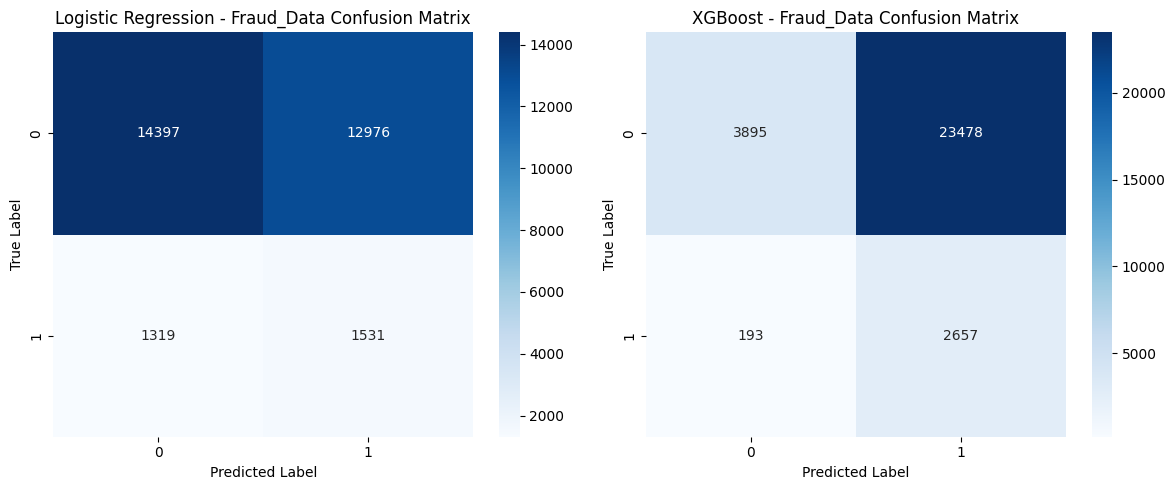

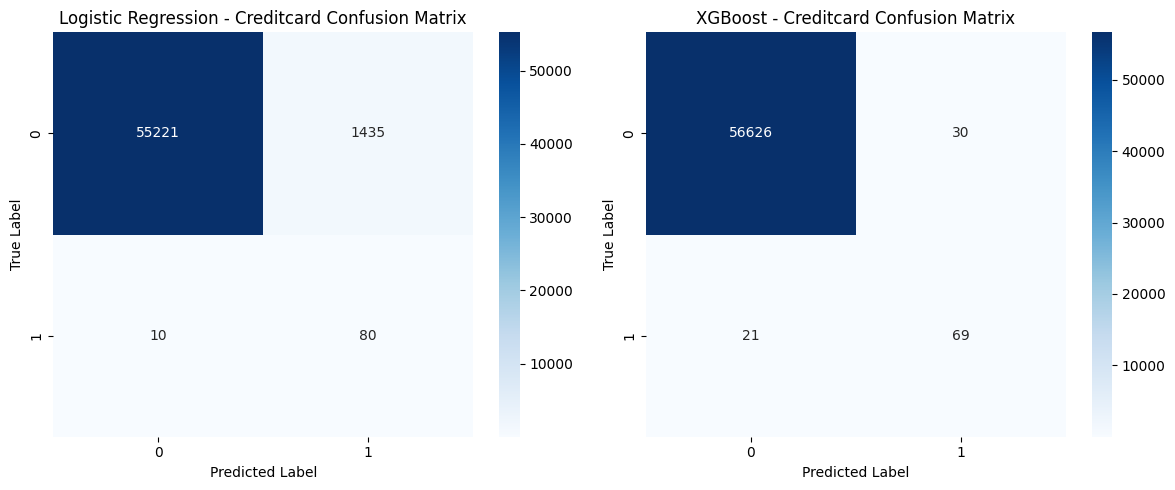

In [7]:
# Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lr_fraud, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Fraud_Data Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb_fraud, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Fraud_Data Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lr_credit, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Creditcard Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb_credit, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Creditcard Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

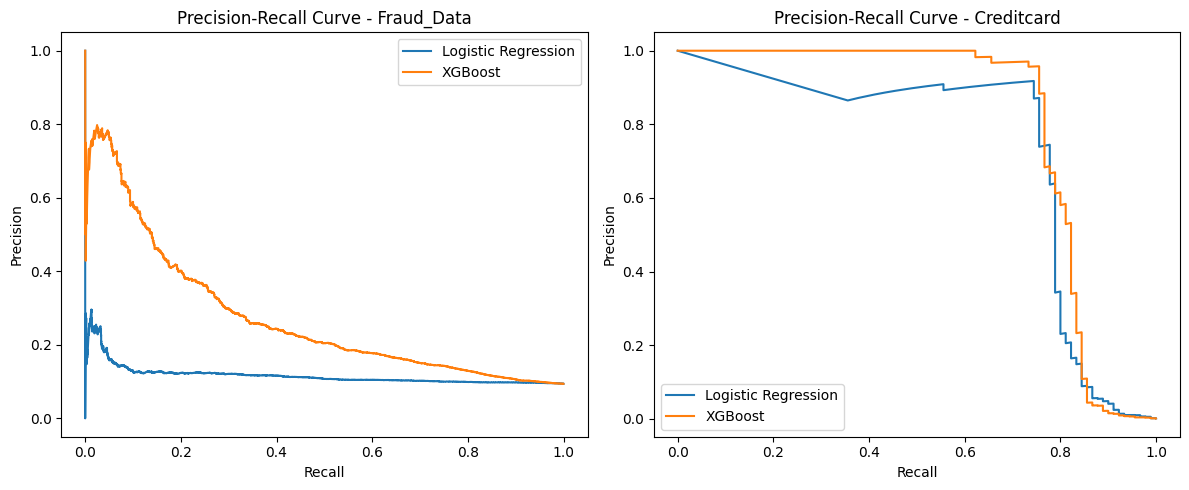

In [8]:
# Precision-Recall Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rec_lr_fraud, prec_lr_fraud, label='Logistic Regression')
plt.plot(rec_xgb_fraud, prec_xgb_fraud, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Fraud_Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec_lr_credit, prec_lr_credit, label='Logistic Regression')
plt.plot(rec_xgb_credit, prec_xgb_credit, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Creditcard')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison and Justification

### Results Summary
- **Logistic Regression Results:**
  - Fraud_Data: AUC-PR: 0.1162, F1-Score: 0.1764
  - Creditcard: AUC-PR: 0.7313, F1-Score: 0.0997
- **XGBoost Results:**
  - Fraud_Data: AUC-PR: 0.2733, F1-Score: 0.1833
  - Creditcard: AUC-PR: 0.8055, F1-Score: 0.7302

### Best Model Justification
The **XGBoost** model is considered the best based on the evaluation metrics. XGBoost outperforms Logistic Regression with a higher average AUC-PR (0.5394 vs. 0.4238), indicating a better balance of precision and recall across both datasets, which is critical for imbalanced fraud detection tasks. Specifically, XGBoost shows a significant improvement on the Creditcard dataset (AUC-PR: 0.8055, F1-Score: 0.7302) compared to Logistic Regression (AUC-PR: 0.7313, F1-Score: 0.0997), demonstrating better handling of the minority fraud class. On Fraud_Data, while the improvement is modest (AUC-PR: 0.2733 vs. 0.1162), XGBoost still provides a more robust performance. The ensemble nature of XGBoost, combined with its ability to leverage SMOTE-balanced data, justifies its selection as the superior model for this task.